# DL4H Final Project

## Graph Representation Learning for Familial Relationships

[Link to Github with notebook](https://github.com/cosmocat27/ehr_graph_replica/tree/main)

[Link to presentation video](https://mediaspace.illinois.edu/media/t/1_0alp2wex)

[Link to original paper](https://arxiv.org/pdf/2304.05010.pdf)

[Link to original Github](https://github.com/dsgelab/family-EHR-graphs)

(This notebook should be run in a python colab environment so that the setup works as expected)

---

# Introduction

## Background of the problem

The general problem is that of using family medical history to predict disease. Solving this problem would mean more accurate prediction and understanding of certain heritable diseases, leading to more useful medical interventions. Family history is a well-established indicator of health risks, but its assessment is often
complicated by the interactions of genetic, environmental, and lifestyle factors. The wide
availability of EHR presents opportunities for deep learning to learn complex representations of
patient data that would be useful in clinical prediction.

Various methods have been used to model family history and heriditary disease, including polygenic risk scoring methods and BLUP, but these approaches are limited by data availability such as genetic data. Alternatively, there are clinical baselines that use rule-based and MLP approaches that do not consider graphical information, but do not perform as well as graph based approaches.

## Paper explanation

This paper formulates disease risk prediction from family history as a graph modeling problem, and uses graph-based deep learning and LSTMs to learn supervised representations of the family history. It’s shown that the approach can predict 10-year disease risk better than the baseline approaches, based on AUC-ROC/PRC. Furthermore, graph explainability techniques can be used to identify specific features of the family history that are useful for disease prediction.

The paper did a good job of contributing a novel graph-based method to the research regime and improving on existing performance, and it advances the state of the art on using deep learning to model heritable disease risk.

# Scope of Reproducibility:

## Hypotheses and corresponding experiments


1.   Hypothesis 1: The graph neural network based model provides better performance in predicting 10 year disease onset of certain diseases (adult asthma, colorectal cancer, coronary heart disease, depression and suicide, and type two diabetes), compared to the baseline (rule-based or static MLP). To test this, we will run the full GNN model and compare the AUC-ROC/PRC results with the baseline models.
2.   Hypothesis 2: Features for family history provide incremental predictive value when used in a graph neural network to classify a patient’s development of disease within 10 years. To test this, we will run the ablation studies proposed in the paper, which incrementally add family history and graph connectivity features to a baseline model to understand their incremental value.

# Methodology

## Setup (Environvment)

This notebook runs on Python 3.10.12.

In [ ]:
# import files from Github, and install dependencies
!git clone https://github.com/dsgelab/family-EHR-graphs.git
!git clone https://github.com/cosmocat27/ehr_graph_replica.git
!pip install torch_geometric
!mkdir results

import sys
sys.path.append('/content/family-EHR-graphs/src')

### Optional data generation step. The synthetic dataset has been uploaded to Github.
#import os
#os.environ['LD_LIBRARY_PATH'] = os.environ.get("LD_LIBRARY_PATH") + ":/content/gsl-2.7/.libs"

#!wget "https://ftp.gnu.org/gnu/gsl/gsl-2.7.tar.gz" && tar -xvzf gsl-2.7.tar.gz
#!cd gsl-2.7 && ./configure && make && make install
#!gcc "/content/drive/My Drive/project/SimPedPheno_V1.1.c" -o PhenoPedSim -Lgsl_lib_directory -Igsl_include_directory -lm -lgsl -fPIC -lcblas -lblas
#!./PhenoPedSim "/content/drive/My Drive/project/syn_data_params_1.txt" 1000

In [ ]:
# import packages you need
import argparse
import torch
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from data import DataFetch, Data, GraphData
from torch_geometric.loader import DataLoader
from model import Baseline, BaselineLongitudinal, GNN, GNNLongitudinal, GNNExplainabilityLSTM
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from utils import EarlyStopping, get_classification_threshold_auc, get_classification_threshold_precision_recall, WeightedBCELoss
import explainability
import json

from main import *

# set the seed
seed = 1000
np.random.seed(seed)
torch.manual_seed(seed)

In [16]:
# setup the params to be used for the first experiment

sqlpath = 'long.db'
params = {'model_type':'graph',
        'gnn_layer':'graphconv',
        'pooling_method':'target',
        'outpath':'results',
        'outname':'G2_TestDisease',
        'obs_window_start':1990,
        'obs_window_end':2010,
        'batchsize':250,
        'num_workers':6,
        'max_epochs':100,
        'patience':8,
        'learning_rate':0.001,
        'main_hidden_dim':20,
        'lstm_hidden_dim':20,
        'loss':'bce_weighted_sum',
        'gamma':1,
        'alpha':1,
        'beta':1,
        'delta':1,
        'dropout_rate':0.5,
        'threshold_opt':'precision_recall',
        'ratio':0.5,
        'local_test':True,
        'explainability_mode':False,
        'embeddings_mode':False,
        'explainer_input':'',
        'device_specification':'na',
        'num_positive_samples':5000}

if params['device_specification'] != 'na':
    params['device'] = torch.device(params['device_specification'])
else:
    params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using {} device".format(params['device']))

Using cpu device


##  Data
### Data description and download instructions

The experiments in the paper use a nationwide health registry dataset, which cannot be publicly
shared for data privacy reasons. Instead, the authors have provided code and instructions for
generating synthetic datasets that mimic the real dataset. I am using the synthetic dataset provided with the code at https://github.com/dsgelab/family-EHR-graphs/tree/main/test.

The data consist of 4 different file types:

**Maskfile**: Specifies which samples belong to the target cohort (patients to predict health outcomes for) and which samples belong to the graph cohort (relatives of the target patients). This file also specifies the train, validation and test split for the dataset.

**Statfile**: Contains the (static node) feature dataset for all samples in both the target and graph cohorts. This file also contains the data for the label being predicted for the binary classification task.

**Edgefile**: Contains the edge pairs for the family graphs, where each patient in the target cohort has a separate family graph. This file also contains the data for the edge features.

**Featfile**: Specifies which features to use for training the model, for 4 types of features: static, longitudinal, label and edge.

In [17]:
# dir and function to load the raw data
raw_data_dir = 'family-EHR-graphs/test/'
maskfile_path = raw_data_dir + 'Gen3_50k_0.7_142857_maskfile.csv'
statfile_path = raw_data_dir + 'Gen3_50k_0.7_142857_statfile.csv'
edgefile_path = raw_data_dir + 'Gen3_50k_0.7_142857_edgefile.csv'

def load_raw_data(maskfile_path, statfile_path, edgefile_path):
  masks = pd.read_csv(maskfile_path)
  stats = pd.read_csv(statfile_path)
  edges = pd.read_csv(edgefile_path)
  return masks, stats, edges

masks, stats, edges = load_raw_data(maskfile_path, statfile_path, edgefile_path)

filepaths = {'maskfile':maskfile_path,
            'featfile':raw_data_dir + 'featfiles/featfile_G2.csv',
            'alt_featfile':raw_data_dir + 'featfiles/featfile_A5.csv',
            'statfile':statfile_path,
            'edgefile':edgefile_path}

### Statistics with visualizations

**Size:**

* Maskfile: 150k rows, 5 columns
* Statfile: 150k rows, 33 columns
* Edgefile: 1.1M rows, 14 columns
* Featfile: Depends on the model, but only a few rows specifying the features.

**Label distribution:**

150k total patients

Target population (patients): 4357 positive, 34940 negative

Non-target population (relatives): 57763 positive, 52940 negative

**Cross validation split:**

Out of 39k target patients

28k train, 4k validation, 8k test

**Figure 1: Graph of an example patient**

![graph_viz.png](https://drive.google.com/uc?export=view&id=1Dre0B39ofm9d2HeRRAVjvDfqgzfYdCUQ)

Maskfile size: 150000 rows, 5 columns
Statfile size: 150000 rows, 33 columns
Edgefile size: 1102849 rows, 14 columns
Target population: 34940 positive, 4357 negative
Non-target population: 57763 positive, 52940 negative
Cross validation split: 27565 train, 3872 validation, 7860 test



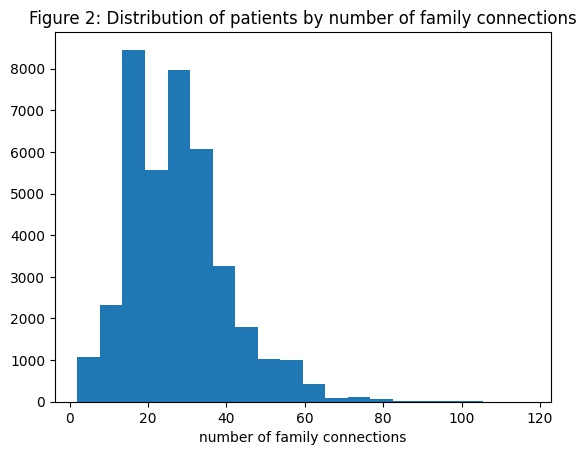

In [18]:
# calculate statistics
def calculate_stats(masks, stats, edges):
  n_rows, n_columns = masks.shape
  print("Maskfile size: {} rows, {} columns".format(n_rows, n_columns))
  n_rows, n_columns = stats.shape
  print("Statfile size: {} rows, {} columns".format(n_rows, n_columns))
  n_rows, n_columns = edges.shape
  print("Edgefile size: {} rows, {} columns".format(n_rows, n_columns))

  target_pos, target_neg = stats[masks['target']==1].EndPtStat.value_counts().sort_index().values
  print("Target population: {} positive, {} negative".format(target_pos, target_neg))
  nontarget_pos, nontarget_neg = stats[masks['target']==0].EndPtStat.value_counts().sort_index().values
  print("Non-target population: {} positive, {} negative".format(nontarget_pos, nontarget_neg))
  nontarget, train, valid, test = masks.train.value_counts().sort_index().values
  print("Cross validation split: {} train, {} validation, {} test".format(train, valid, test))
  print()
  return None

calculate_stats(masks, stats, edges)

edges.target_patient.value_counts().hist(bins=20)
plt.xlabel("number of family connections")
plt.title("Figure 2: Distribution of patients by number of family connections")
plt.grid(False)

Text(0.5, 1.0, 'Figure 3: Most common node-node relationships in the family dataset')

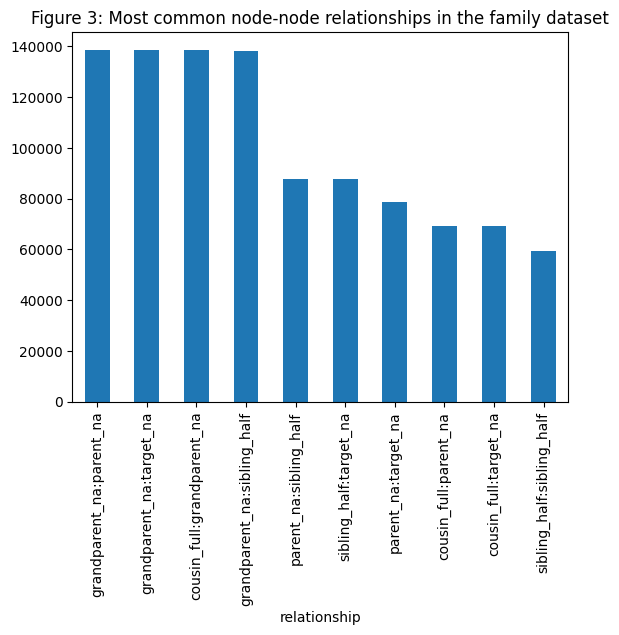

In [19]:
edges.relationship.value_counts()[:10].plot(kind="bar")
plt.title("Figure 3: Most common node-node relationships in the family dataset")

### Data processing

Most of the data is processed already via data generation. We use the provided function DataFetch to split the data into train / validation / test sets, then use get_data_and_loader to prepare the datasets for modeling.

In [ ]:
fetch_data = DataFetch(filepaths['maskfile'], filepaths['featfile'], filepaths['statfile'], filepaths['edgefile'], sqlpath, params, alt_featfile=filepaths['alt_featfile'], local=params['local_test'])

train_patient_list = fetch_data.train_patient_list
params['num_batches_train'] = int(np.ceil(len(train_patient_list)/params['batchsize']))
params['num_samples_train_dataset'] = len(fetch_data.train_patient_list)
params['num_samples_train_minority_class'] = fetch_data.num_samples_train_minority_class
params['num_samples_train_majority_class'] = fetch_data.num_samples_train_majority_class
validate_patient_list = fetch_data.validate_patient_list
params['num_batches_validate'] = int(np.ceil(len(validate_patient_list)/params['batchsize']))
params['num_samples_valid_dataset'] = len(fetch_data.validate_patient_list)
params['num_samples_valid_minority_class'] = fetch_data.num_samples_valid_minority_class
params['num_samples_valid_majority_class'] = fetch_data.num_samples_valid_majority_class
test_patient_list = fetch_data.test_patient_list
params['num_batches_test'] = int(np.ceil(len(test_patient_list)/params['batchsize']))

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, params, shuffle=True)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, params, shuffle=True)
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, params, shuffle=False)
params['include_longitudinal'] = train_dataset.include_longitudinal
params['num_features_static'] = len(fetch_data.static_features)
if params['model_type'] in ['graph', 'graph_no_target', 'explainability']: params['num_features_alt_static'] = len(fetch_data.alt_static_features)
params['num_features_longitudinal'] = len(fetch_data.longitudinal_features)

##   Model

### Citation of original paper
1.   Sophie Wharrie, Zhiyu Yang, Andrea Ganna, Samuel Kaski. (2023). Characterizing personalized
effects of family information on disease risk using graph representation learning. Proceedings of
the 8th Machine Learning for Healthcare Conference, in Proceedings of Machine Learning
Research. 219:824-845. Available from https://arxiv.org/abs/2304.05010.

### Link to the original Repo
[Link to Github](https://github.com/dsgelab/family-EHR-graphs)

--

### Model architecture
The GNN Longitudinal model is a graph embedding model that consists of two separate paths for family-based data and patient-based data, which get combined into final classification.

**Figure 4: Architecture of GNN model (from the paper's Github)**
![model_architecture.png](https://drive.google.com/uc?export=view&id=1Bt3MowFOdxNaNwn-aFCj1Pdvc5ITiOxM)

The patient part consists of LSTM, Linear, and Dropout layers with ReLU activation.

The family part consists of LSTM and graph convolutional layers (with GCN), with ReLU activation.

The combined part concatenates the patient and family outputs and passes them through a linear layer and sigmoid activation function to get the final output.

### Implemention
The implementation of the GNN longitudinal model can be found on [Github](https://github.com/dsgelab/family-EHR-graphs/blob/main/src/model.py#L123).

### Pretrained model
The pretrained version of the model can be found on [Github](https://github.com/cosmocat27/ehr_graph_replica/blob/main/results_G2/G2_TestDisease_model.pth).

The model was trained on the synthetic dataset. We will run 1 iteration of training for demonstration.


## Model Training

### Training objectives (Hyperparameters)
Loss function: WeightedBCELoss (BCELoss with weights adjusted for class imbalance)

Optimizer: Adam (with learning rate = 0.001)

### Hyperparameters
Learning rate: 0.001

Batch size: 250

Dropout Rate: 0.5

Max Epochs: 100 (for the pretrained model)

### Computational requirements
Hardware: Google Compute Engine (CPU)

RAM used: 4.2 GB

Disk used: 26.2 GB

Average runtime per epoch: 189s

Number of training epochs: 41

--

The function train_model is implemented in the [Github](https://github.com/dsgelab/family-EHR-graphs/blob/main/src/main.py#L47).

In [25]:
model = get_model(params)
model_path = '{}/{}_model.pth'.format(params['outpath'], params['outname'])

optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
if params['loss']=='bce_weighted_single' or params['loss']=='bce_weighted_sum':
  train_criterion = WeightedBCELoss(params['num_samples_train_dataset'], params['num_samples_train_minority_class'], params['num_samples_train_majority_class'], params['device'])
  valid_criterion = WeightedBCELoss(params['num_samples_valid_dataset'], params['num_samples_valid_minority_class'], params['num_samples_valid_majority_class'], params['device'])

# normal training model
del fetch_data # free up memory no longer needed
del train_dataset
del validate_dataset
del test_dataset

# model training (we run 1 epoch just for demonstration)
params['max_epochs'] = 1
start_time_train = time.time()
# train the model for at most max_epochs
model, threshold = train_model(model, train_loader, validate_loader, params)
end_time_train = time.time()
# we will load the pretrained model
#torch.save(model.state_dict(), model_path)
threshold = 0.639   # threshold determined from training
params['threshold'] = threshold
params['training_time'] = end_time_train - start_time_train

Using graph model with longitudinal data
Using GraphConv layers
Using BCE weighted loss


  0%|          | 0/111 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 111/111 [02:51<00:00,  2.56it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


epoch 0	train loss : 6.58013289683574	validate loss : 5.5371546149253845


<Figure size 640x480 with 0 Axes>

**Figure 5: Loss shrinkage for GNN model**

![loss_shrinkage.png](https://drive.google.com/uc?export=view&id=1D3T-qjw5mYLfL8h5X9NwEVT2w3IDtbSI)

## Model Evaluation

### Metrics used

**Accuracy:** Percent of patients that were correctly classified

**Recall:** Precent of positive labels that were classified as true positive

**Precision:** Percent of positive predictions that were true positive labels

**F1 score:** 2 * recall * precision / (recall + precision)

**ROC_AUC:** Area under the ROC curve

--

The results are summarized under Results.

The function test_model is implemented in the [Github](https://github.com/dsgelab/family-EHR-graphs/blob/main/src/main.py#L227).

In [26]:
model_path = 'ehr_graph_replica/results_G2/G2_TestDisease_model.pth'
results_path = '{}/{}_results.csv'.format(params['outpath'], params['outname'])
stats_path = '{}/{}_stats.csv'.format(params['outpath'], params['outname'])
model.load_state_dict(torch.load(model_path))

# model testing
results, metric_results = test_model(model, test_loader, threshold, params)
results.to_csv(results_path, index=None)
params.update(metric_results)
stats = pd.DataFrame({'name':list(params.keys()), 'value':list(params.values())})
stats.to_csv(stats_path, index=None)

  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 32/32 [00:42<00:00,  1.33s/it]


# Results

This section summarizes the results of the models we have tested. The main model from the paper is the GNN model with longitudinal data. In addition, we provide results of the other models used for ablation studies, the results of which we load directly.

## GNN model with longitudinal data (main model)

**Test set size:** 7860

**Accuracy:** 0.77

**Recall:** 0.64

**Precision:** 0.28

**F1 Score:** 0.388

**ROC_AUC:** 0.803

--

A discussion of these results along with ablation studies is provided under Analysis.

In [27]:
# load the results directly if we did not run the model in the previous step
#results = pd.read_csv('ehr_graph_replica/results_G2/G2_TestDisease_results.csv')
#stats = pd.read_csv('ehr_graph_replica/results_A2/G2_TestDisease_stats.csv')

y_true = results['actual']
y_score = results['pred_raw']
y_pred = results['pred_binary']

# metrics to evaluate my model
result_df = pd.Series()
result_df['Accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 3)
result_df['Recall'] = round(metrics.recall_score(y_true, y_pred), 3)
result_df['Precision'] = round(metrics.precision_score(y_true, y_pred), 3)
result_df['F1'] = round(metrics.f1_score(y_true, y_pred), 3)
result_df['ROC'] = round(metrics.roc_auc_score(y_true, y_score), 3)

result_df

Accuracy     0.771
Recall       0.638
Precision    0.273
F1           0.382
ROC          0.800
dtype: float64

## Ablation results

We conducted the following ablation studies in order to understand the incremental predictive value of family history and graph connectivity features:
* Baseline model with age and sex data
* Age, sex, and family history MLP
* Age, sex, and graph connectivity MLP
* GNN with longitudinal data (main model for comparison)

In [28]:
# load the results directly (we trained and ran the model separately)
models = ["A1", "A2", "A3", "G2"]
metric_list = ["Accuracy", "Recall", "Precision", "F1", "ROC"]
columns = ["Baseline", "+Family history", "+Graph connectivity"]
model_to_column = {
    "A1": "Baseline",
    "A2": "+Family history",
    "A3": "+Graph connectivity",
    "G2": "+Graph embedding"
}
result_df = pd.DataFrame(index = metric_list, columns = columns)

for m in models:
  results = pd.read_csv('ehr_graph_replica/results_{}/{}_TestDisease_results.csv'.format(m, m))
  stats = pd.read_csv('ehr_graph_replica/results_{}/{}_TestDisease_stats.csv'.format(m, m))
  y_true = results['actual']
  y_score = results['pred_raw']
  y_pred = results['pred_binary']
  col = model_to_column[m]

  # metrics to evaluate my model
  result_df.loc['Accuracy', col] = round(metrics.accuracy_score(y_true, y_pred), 3)
  result_df.loc['Recall', col] = round(metrics.recall_score(y_true, y_pred), 3)
  result_df.loc['Precision', col] = round(metrics.precision_score(y_true, y_pred), 3)
  result_df.loc['F1', col] = round(metrics.f1_score(y_true, y_pred), 3)
  result_df.loc['ROC', col] = round(metrics.roc_auc_score(y_true, y_score), 3)

result_df

,Baseline,+Family history,+Graph connectivity,+Graph embedding
Accuracy,0.651,0.734,0.669,0.761
Recall,0.505,0.629,0.493,0.649
Precision,0.16,0.237,0.166,0.265
F1,0.243,0.344,0.249,0.377
ROC,0.626,0.768,0.638,0.800


Text(0.5, 1.0, 'Figure 6: Metrics for the different models in the study')

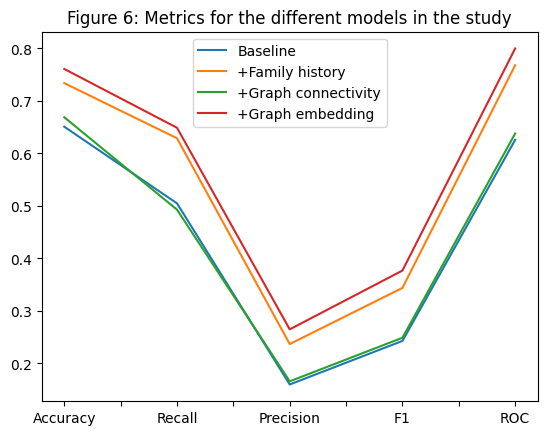

In [29]:
result_df.plot()
plt.title("Figure 6: Metrics for the different models in the study")

## Analysis

The two main hypotheses made in this experiment were:

1.   Hypothesis 1: The graph neural network based model provides better performance in predicting 10 year disease onset compared to the baseline MLP model.
2.   Hypothesis 2: Features for family history provide incremental predictive value when use in a graph neural network to classify a patient’s development of disease.

The results suggest that the Graph-based model with longitudinal data outperforms non graph-based models when making predictions on the synthetic dataset. They also suggset that family history plays a significant role in the prediction of the disease, since models that included family history performed significantly better. Therefore, we think the results support the original hypotheses.

Further experiments could explore different combinations of features or look into how the models perform on datasets with different characteristics like heritability to see if the pattern continues to hold.

A comparison of the model performance for the replicated experiment versus those of the original paper is shown below.

--

**Results of models in the paper for predicting coronary heart disease (AUC-ROC):**

Baseline model with age and sex data: 0.696

Age, sex and family history MLP: 0.710

Age, sex and graph connectivity MLP: 0.696

GNN model with longitudinal data: 0.775

**Results of models in replicated experiment for predicting on synthetic dataset (AUC-ROC):**

Baseline model with age and sex data: 0.626

Age, sex and family history MLP: 0.768

Age, sex and graph connectivity MLP: 0.638

GNN model with longitudinal data: 0.803

# Discussion

Based on the experiment, we were able to reproduce two of the major findings in the paper, which were 1) that graph based representation learning based on family history provides better preditive value over non-graph based models, and 2) family history is a significant factor in how well the model performs, since all models that included family history performed significantly better than those that did not.

Of course, we should note the caveat that this was using synthetic data instead of the real dataset, which may yield different results. This is probably the major contributing gap between the original results and the replicated results.

The easy part was that most of the code for producing the data and training the models was available in the Github, making it relatively easy for someone to run similar code in their own environment. The difficult part is that it's not easy to compare the results of the new dataset with those of the original dataset, due to their different sources.

The authors might consider going into detail about some methods that use less sensitive data that can be accessed more widely, even though it is not optimal, so that follow-up experiments can compared using the same datasets.

# Public Github Repo and Presentation

[Link to Github with notebook](https://github.com/cosmocat27/ehr_graph_replica/tree/main)

[Link to presentation video](https://mediaspace.illinois.edu/media/t/1_0alp2wex)

# References

1.   Sophie Wharrie, Zhiyu Yang, Andrea Ganna, Samuel Kaski. (2023). Characterizing personalized
effects of family information on disease risk using graph representation learning. Proceedings of
the 8th Machine Learning for Healthcare Conference, in Proceedings of Machine Learning
Research. 219:824-845. Available from https://arxiv.org/abs/2304.05010.